In [0]:
import os
import sys
import importlib
import moten
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random

print(sys.path)
%pwd

os.chdir('/home/rfpred')
sys.path.append('/home/rfpred/')
sys.path.append('/home/rfpred/envs/rfenv/lib/python3.11/site-packages/')
sys.path.append('/home/rfpred/envs/rfenv/lib/python3.11/site-packages/nsdcode')

from classes.voxelsieve import VoxelSieve
from classes.natspatpred import NatSpatPred
NSP = NatSpatPred()
NSP.initialise(verbose=False)

from funcs.gaborpyr import (
    isotropic_gaussian,
    circle_stim,
    random_dot,
    show,
    cut_corners,
    make_checker,
    plot_filter_locations,
    plot_filter_outputs,
    normalize_output,
    cut_paste_mask,
)

# file_exists = os.path.isfile(f"{NSP.own_datapath}/visfeats/gabor_pyramid/gauss_checker_output.npy")


['/home/rfpred/notebooks/construction_work', '/home/rfpred/envs/rfenv/lib/python311.zip', '/home/rfpred/envs/rfenv/lib/python3.11', '/home/rfpred/envs/rfenv/lib/python3.11/lib-dynload', '', '/home/rfpred/envs/rfenv/lib/python3.11/site-packages', '/home/rfpred/notebooks/alien_nbs/lgnpy', '/home/rfpred/envs/rfenv/lib/python3.11/site-packages/nsd_access-0.0.1.dev0-py3.11.egg', '/home/rfpred/envs/rfenv/lib/python3.11/site-packages/cifti-1.1-py3.11.egg']


In [2]:
rois, roi_masks, viscortex_mask = NSP.cortex.visrois_dict(verbose=False)
prf_dict = NSP.cortex.prf_dict(rois, roi_masks)

In [4]:
subject = "subj01"
max_size = 2
min_size = .15
patchbound = 1
min_nsd_R2 = 0
min_prf_R2 = 0
# fixed_n_voxels = 170
voxeldict = {}
n_voxels = []

peri_angle=90 # 90, 210, 330
peri_ecc=2.0


for roi in rois:
    while True:
        print_attr = True if roi == rois[len(rois) - 1] else False
        voxeldict[roi] = VoxelSieve(
            NSP,
            prf_dict,
            roi_masks,
            subject=subject,
            roi=roi,
            patchloc="peripheral",
            max_size=max_size,
            min_size=min_size,
            patchbound=patchbound,
            min_nsd_R2=min_nsd_R2,
            min_prf_R2=min_prf_R2,
            print_attributes=False, 
            fixed_n_voxels=None,
            peripheral_center=None,
            peri_angle=peri_angle,
            peri_ecc=peri_ecc,
            leniency = 0.25,
            verbose=False
        )
        if len(voxeldict[roi].size) > 0:
            break
        else:
            patchbound += 0.1
            print(f"No voxels found for ROI {roi} with patchbound {patchbound - 0.1}. Trying with patchbound {patchbound}.")
    n_voxels.append(len(voxeldict[roi].size))


V1 voxels that fulfill requirements: 71 out of 7887.
V2 voxels that fulfill requirements: 89 out of 8296.
V3 voxels that fulfill requirements: 18 out of 7022.
V4 voxels that fulfill requirements: 15 out of 3976.


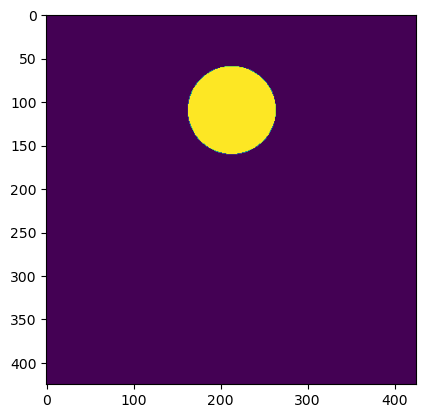

In [121]:
plt.imshow(voxeldict["V1"].patchmask)

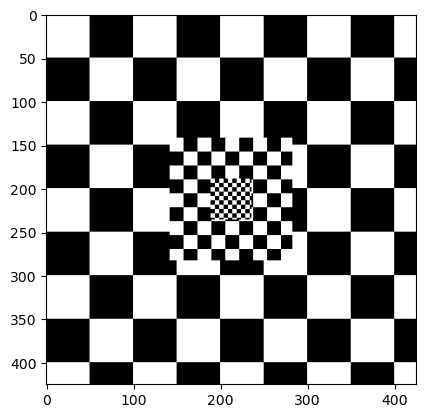

In [6]:
checker_stim = make_checker(
    dims=(425, 425),
    checkercenter=(212, 212),
    # checkercenter=(100, 212),
    scales=2,
    scaling_factor=3,
    checker_size=50,
    stride=0,
)

plt.imshow(checker_stim, cmap="binary")

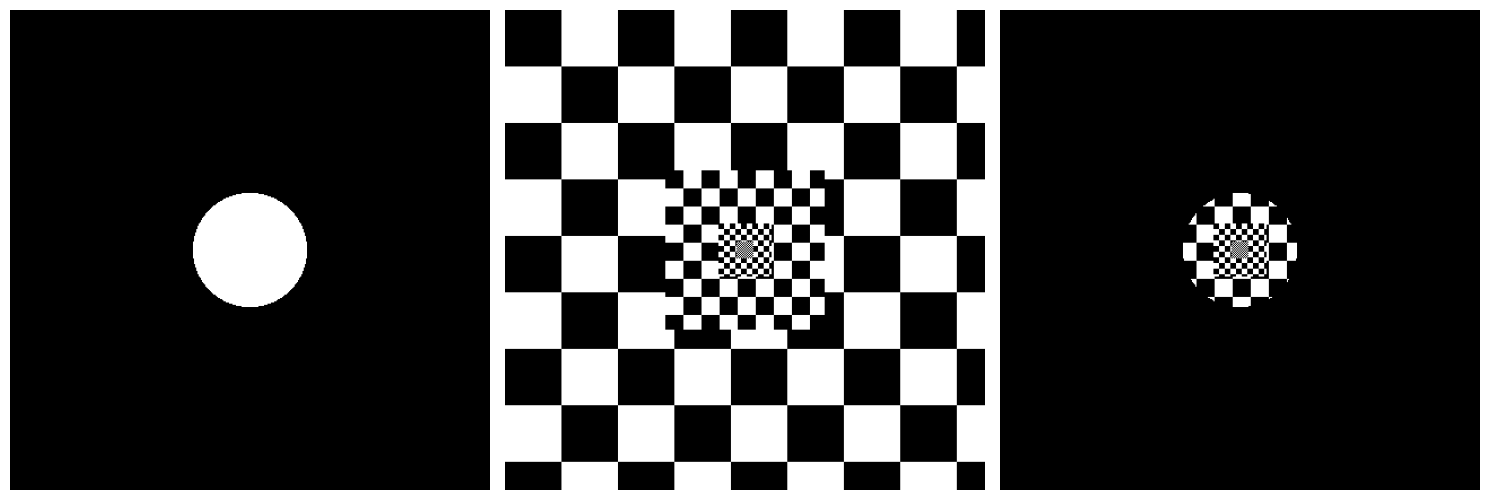

In [4]:
pixels = 425
degrees = 8.4
pix_per_deg = pixels / degrees

cirkel = circle_stim((425, 425), (1 * pix_per_deg), (212, 212))

checker_stim = make_checker(
    dims=(425, 425),
    # checkercenter=(212, 212),
    checkercenter=(100, 212),
    scales=3,
    scaling_factor=3,
    checker_size=50,
    stride=0,
)


fig, axes = plt.subplots(1, 3, figsize=(15, 6))

for img_no, img in enumerate([cirkel, checker_stim, checker_stim * cirkel]):
    axes[img_no].imshow(img, cmap="gist_gray")
    axes[img_no].axis("off")
plt.tight_layout()

circ_check_stack = np.stack([cirkel, checker_stim * cirkel], axis=0)

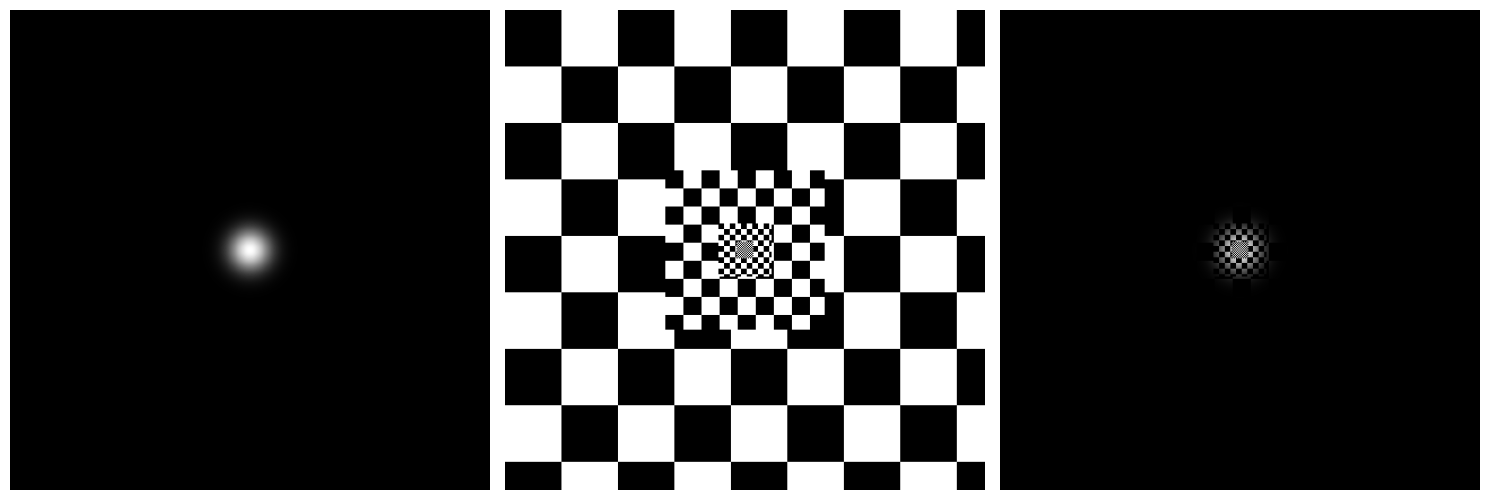

In [5]:
gauss = isotropic_gaussian(dims=(425,425), sigma=pix_per_deg/4) # Justify this 2.5 factor

checker_stim = make_checker(dims=(425,425), checkercenter=(212,212), scales=3, scaling_factor=3, checker_size=50, stride=0)

fig, axes = plt.subplots(1, 3, figsize=(15,6))

for img_no, img in enumerate([gauss, checker_stim, checker_stim * gauss]):
    axes[img_no].imshow(img, cmap='gist_gray')
    axes[img_no].axis("off")
plt.tight_layout()

gauss_check_stack = np.stack([gauss, checker_stim * gauss], axis=0)


The desired patch location has: 2.0 degrees eccentricity at 210 degrees polar angle at coordinates (-1.73, -1.0).
Which requires the patch center to be shifted -87 pixels horizontally and -50 pixels vertically.


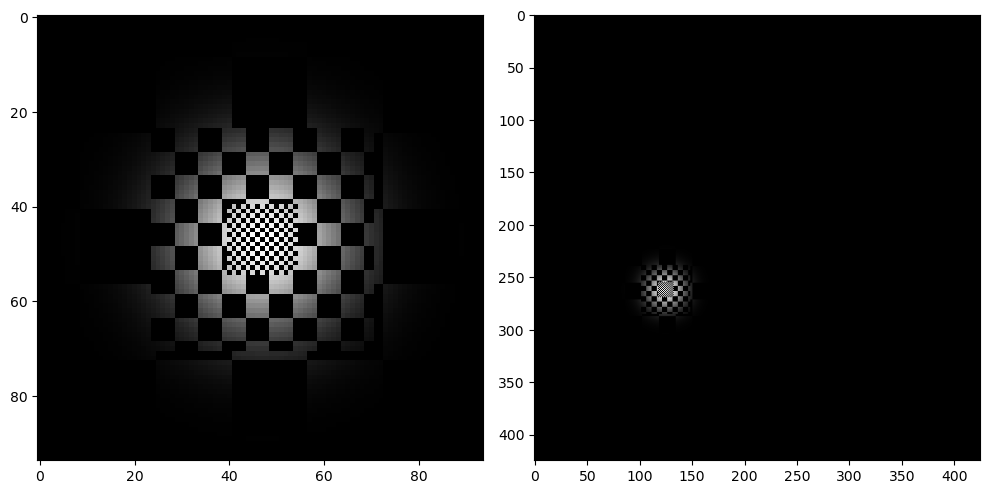

In [16]:
gauss = isotropic_gaussian(dims=(425,425), sigma=pix_per_deg/4) # Justify this 2.5 factor

checker_stim = make_checker(dims=(425,425), checkercenter=(212,212), scales=3, scaling_factor=3, checker_size=50, stride=0)

gauss_check_stack = np.stack([gauss, checker_stim * gauss], axis=0)

peri_patch = cut_paste_mask(gauss_check_stack, 210, 2.0, verbose=True, plot=True)
peri_gauss = cut_paste_mask(np.stack([gauss, gauss], axis=0), 210, 2.0, verbose=False, plot=False)
gauss_check_stack_peri = np.stack([peri_gauss, peri_patch], axis=0)
